<center> <a href="https://github.com/CyConProject?tab=repositories">
  <img src="https://github.com/CyConProject/Lab/blob/main/Figures/CyCon.png?raw=true" alt="logo" width="80" >
</a>
 </center>


## Artificial Neural Networks – Forward Propagation


Civil infrastructure, bridges, tunnels, heavy machinery, benefits from **continuous monitoring** of vibration, strain, and temperature. By training tiny neural nets to predict “failure risk,” we can schedule maintenance *before* a major breakdown. In this lab, you’ll:

* **By hand:** compute how sensor readings flow through a 2-layer network.
* **In code:** write helper functions (`compute_z`, `relu`, `sigmoid`), build a general `forward_propagate()` routine, and test on different network shapes.

> **Why by hand?** Modern frameworks like Keras hide every detail. Manually calculating every $z$ and $a$ gives you an intuitive grasp of what actually happens in each layer.



### Objectives

1. Manually compute weighted sums and activations for a small 2-node hidden layer network.
2. Implement and test helper functions for $z$ and activation functions.
3. Write `initialize_network()` and `forward_propagate()` to handle arbitrary small networks.
4. Experiment with deeper architectures and alternative activations.


## 1. Recap: Forward Propagation Theory

A single neuron computes

$$
  z = \sum_i w_i x_i + b,
  \quad
  a = \phi(z)
$$

where $\phi$ is an activation function (e.g. ReLU or Sigmoid).

**Layer by layer:**

1. Inputs $\mathbf{x}$ → hidden layer → activations $\mathbf{a}^{(1)}$.
2. $\mathbf{a}^{(1)}$ → output layer → final activations $\mathbf{a}^{(2)}$.

> **Note:** ReLU($z$) = max(0, $z$). Sigmoid($z$) = $1/(1+e^{-z})$.

> **Further explanation**: The Rectified Linear Unit (ReLU) activation function is popular because of its simplicity and effectiveness. By zeroing out all negative inputs, ReLU introduces sparsity into the network: any neuron receiving a negative weighted sum is effectively "turned off." This sparsity helps reduce inter-neuron dependencies and makes the model less likely to overfit. Moreover, since ReLU has a constant gradient of 1 for positive values, it mitigates the vanishing gradient problem that plagues sigmoid or tanh in deep networks, ensuring stronger gradient signals during backpropagation. Finally, its piecewise-linear form is computationally efficient, requiring only a comparison with zero for each element.



## 2. Part I – Manual Forward Pass

### 2.1 Network Diagram


<center>
  <img src="https://github.com/CyConProject/Lab/blob/main/Figures/Slide1.JPG?raw=true" alt="diagram" width="700" >
</a>
 </center>

### 2.2 Given Sensor Inputs & Parameters

In [3]:
import numpy as np

# Sensor readings (one snapshot):
x1, x2, x3 = 0.8,  65.0, 0.15  
# (vibration, temperature, tilt)

# Hidden-layer parameters:
w11, w12, w13 = 0.10, -0.08, 0.05   # node₁ weights
b1               =  0.02            # node₁ bias
w21, w22, w23 = -0.12,  0.15, 0.03   # node₂ weights
b2               = -0.04            # node₂ bias

# Output-layer parameters:
w31, w32       = 0.20, -0.25        # connects a₁, a₂ → output
b3               =  0.01            # output bias

#### 2.2.1 Compute Hidden‐Layer Activations by Hand

1. **Node 1:**

   $$
     z_1 = w_{11}x_1 + w_{12}x_2 + w_{13}x_3 + b_1
   $$

In [ ]:
z1 = # TODO: fill in
a1 = max(0, z1)        # ReLU

2. **Node 2:**

   $$
     z_2 = w_{21}x_1 + w_{22}x_2 + w_{23}x_3 + b_2
   $$

In [ ]:
z2 = # TODO: fill in
a2 = max(0, z2)       # ReLU


3. **Output Node:**

   $$
     z_3 = w_{31}a_1 + w_{32}a_2 + b_3,
     \quad
     a_3 = \frac{1}{1 + e^{-z_3}}
   $$

In [ ]:
z3 = # TODO: fill in
a3 = 1 / (1 + np.exp(-z3))
print(f"Predicted risk = {a3:.4f}")

<details>
<summary> Solutions (click to expand)</summary>

```python
# Hidden node 1
z1 = w11*x1 + w12*x2 + w13*x3 + b1           # 0.10*0.8 + (-0.08)*65.0 + 0.05*0.15 + 0.02 = -5.0925
a1 = max(0, z1)                              # = 0.0

# Hidden node 2
z2 = w21*x1 + w22*x2 + w23*x3 + b2           # -0.12*0.8 + 0.15*65.0 + 0.03*0.15 - 0.04 = 9.6185
a2 = max(0, z2)                              # = 9.6185

# Output
z3 =  w31*a1 + w32*a2 + b3                   #   = 0.20*0 + (-0.25)*9.6185 + 0.01   ≈ -2.3946
a3 = 1/(1 + np.exp(-z3))                     # ≈ 0.0836
```

</details>

> **Note:** When ReLU “kills” a node ($a=0$), that branch contributes nothing to the next layer.


## 3. Part II – Helper Functions

In [4]:
def compute_z(inputs, weights, bias):
    """Dot product + bias."""
    return np.dot(inputs, weights) + bias

def relu(z):
    """ReLU activation."""
    return np.maximum(0, z)

def sigmoid(z):
    """Sigmoid activation."""
    return 1.0 / (1.0 + np.exp(-z))

> **Exercise:** verify compute_z on [1,2,3] with weights [0.1,0.2,0.3] and bias 0.5. You should get $1.9$.

In [ ]:
# To Do  

<details>
<summary> Solutions (click to expand)</summary>

```python
result = compute_z(np.array([1,2,3]), np.array([0.1,0.2,0.3]), 0.5)
print(result)  
```

</details>



## 4. Part III – General Network Initialization

In this section, we move from hard-coded weights to a fully general routine that can create any small feed-forward network. The key points are:

1. **Why Random Initialization?**

   * If all weights start the same, every neuron in a layer computes the same function and learns the same thing.
   * Small random values break this symmetry, so different hidden units learn different features.
   * Scaling by a small factor (e.g. `*0.1`) prevents activations from blowing up or vanishing immediately.

2. **Layer Representation**
   We represent the network as a Python list of “layers,” where each layer is itself a list of node‐dictionaries:

   
   ```python
   [
     [  # Layer 1 (hidden)
       {'weights': array([...]), 'bias': 0.012, 'activation': relu},
       {'weights': array([...]), 'bias':-0.053, 'activation': relu},
       …
     ],
     [  # Layer 2 (output)
       {'weights': array([...]), 'bias': 0.034, 'activation': sigmoid},
     ]
   ]
   ```

   Each node‐dict holds:

   * **weights**: a 1D NumPy array of length = number of inputs to that layer
   * **bias**: a scalar offset
   * **activation**: a function handle (`relu` or `sigmoid`)

3. **The `initialize_network()` Routine**

   * **`np.random.seed(seed)`** ensures reproducibility: same seed → same initial weights every time.
   * We loop first over each hidden layer size, then finally construct the output layer.
   * `prev_size` tracks how many inputs the next layer expects.

In [5]:
def initialize_network(num_inputs, hidden_sizes, num_outputs, seed=42):
    """
    Returns a list of layers; each layer is list of node-dicts:
      [{'weights': array, 'bias': float, 'activation': func}, …]
    """
    np.random.seed(seed)
    layers = []
    prev_size = num_inputs

    # hidden layers
    for size in hidden_sizes:
        layer = []
        for _ in range(size):
            layer.append({
                'weights': np.random.randn(prev_size) * 0.1,
                'bias':    np.random.randn()     * 0.1,
                'activation': relu
            })
        layers.append(layer)
        prev_size = size

    # output layer
    out_layer = []
    for _ in range(num_outputs):
        out_layer.append({
            'weights': np.random.randn(prev_size) * 0.1,
            'bias':    np.random.randn()     * 0.1,
            'activation': sigmoid
        })
    layers.append(out_layer)
    return layers

## 5. Part IV – Forward Propagation Function

Now that we can build arbitrary networks, we need a general procedure to “push” an input vector through all layers.

1. **High-Level Logic**

   * Each layer takes the previous layer’s activations (`inputs`) and computes new activations (`outputs`).
   * We store the final `outputs` list and return it as the network’s prediction(s).

2. **Key Steps**

   * **`compute_z(inputs, weights, bias)`**: a simple dot‐product plus bias (vectorized).
   * **Activation call**: each node’s dictionary holds its activation function; we just call it on the scalar `z`.
   * **Debugging prints**: inserting

     ```python
     print(f"Layer {layer_idx} outputs: {outputs}")
     ```

     helps you verify that shapes and values behave as expected.

3. **Why Copy the Input?**
   We call `x.copy()` to guard against any in-place modifications elsewhere. It’s not strictly necessary here, but is good defensive programming.

4. **Return Value**

   * We return the **raw activations** of the final layer.
   * For a single-output network, this is a list of length 1 (e.g. `[0.0836]`).
   * If you add more output nodes (see Part VI), you’ll get a list of length = number of outputs.

In [6]:
def forward_propagate(network, x):
    """
    network: list of layers; x: 1D numpy array
    Returns: list of output activations
    """
    inputs = x.copy()
    for layer_idx, layer in enumerate(network, start=1):
        outputs = []
        for node in layer:
            z = compute_z(inputs, node['weights'], node['bias'])
            a = node['activation'](z)
            outputs.append(a)
        print(f"Layer {layer_idx} outputs: {outputs}")
        inputs = np.array(outputs)
    return outputs

## 6. Part V – Testing Your Code

1. **Initialize** a network with 3 inputs, two hidden layers $[4, 3]$, and one output.
2. **Generate** a random sensor vector:

   ```python
   x = np.array([0.8, 65.0, 0.15])
   ```
3. **Forward‐propagate** and record the final risk score.

In [7]:
net = initialize_network(num_inputs=3, hidden_sizes=[4,3], num_outputs=1, seed=42)
x = np.array([0.8, 65.0, 0.15])
prediction = forward_propagate(net, x)
print("Final failure risk:", np.round(prediction[0],4))

Layer 1 outputs: [0.0, 0.0, 3.435558091684762, 0.0]
Layer 2 outputs: [0.0, 0.0, 0.0]
Layer 3 outputs: [0.5205520365260287]
Final failure risk: 0.5206


> **Exercise:** Run this cell twice—do you get the *same* result? (Why?)

In [ ]:
# To Do


<details>
<summary> Solutions (click to expand)</summary>

```python
# Initialize and propagate twice:
net = initialize_network(num_inputs=3, hidden_sizes=[4,3], num_outputs=1, seed=42)
x   = np.array([0.8,65.0,0.15])

pred1 = forward_propagate(net, x)
pred2 = forward_propagate(net, x)

print("First run: ", np.round(pred1[0],4))
print("Second run:", np.round(pred2[0],4))
# You will see identical outputs both times.

```

> **Answer:** Yes—you get the same result on each run **because** we call `np.random.seed(42)` inside `initialize_network`, which fixes the weight/bias randomization.

</details>




## 7. Part VI – Experiments & Extensions
> Look at the results of these experiments:
1. **Change** hidden activations from ReLU → Sigmoid. How do intermediate activations change?
2. **Add** a second output node to predict both “failure risk” and “maintenance urgency.”
3. **Scale up:** Increase hidden layers to three of size $[5,4,3]$. What happens to the magnitude of $z$ and $a$?
4. **Plot** the network’s output over a grid of sensor values to see the learned “risk surface.” (Bonus: use Matplotlib.)

> **Note:** In real civil-engineering systems, we train weights via backpropagation on historical failure data. Here you’re only doing inference.

Layer 1 outputs: [0.3324860218013941, 0.1915157999565726]
Layer 2 outputs: [0.4871127913101089]
Experiment 1 output: [0.4871127913101089]
Layer 1 outputs: [0.0, 0.0]
Layer 2 outputs: [0.48841663060348733, 0.45231337489964796]
Experiment 2 outputs: [0.48841663060348733, 0.45231337489964796]
Layer 1 outputs: [0.0, 0.0, 3.435558091684762, 0.0, 1.806730440976179]
Layer 2 outputs: [0.0, 0.0, 0.1243590919777279, 0.20269958665152726]
Layer 3 outputs: [0.05006119085768822, 0.04265759964542391, 0.016422188147122097]
Layer 4 outputs: [0.473001601014144]
Experiment 3 output: [0.473001601014144]
Layer 1 outputs: [0.0, 0.0, 1.0315958464227166, 0.0, 0.47364393392420046]
Layer 2 outputs: [0.0, 0.09476671199033816, 0.0, 0.04059192536340223]
Layer 3 outputs: [0.031831164730027894, 0.06149110937159256, 0.04069662605521838]
Layer 4 outputs: [0.4722210624461294]
Layer 1 outputs: [0.0, 0.0, 1.0306377354310126, 0.0, 0.4715769316378037]
Layer 2 outputs: [0.0, 0.09494863273774537, 0.0, 0.0405450765950837]
Lay

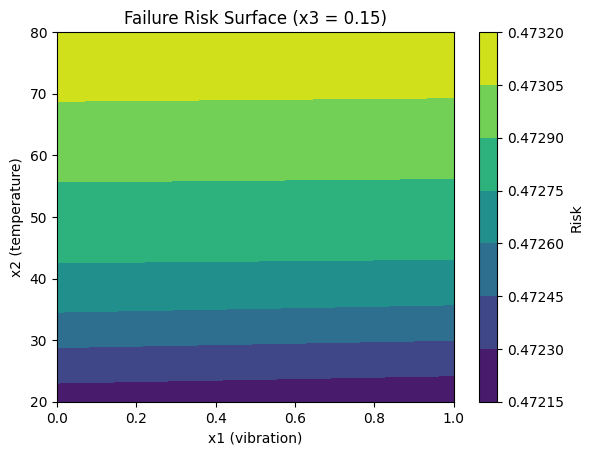

In [8]:
import matplotlib.pyplot as plt
# Fixed sensor input
x = np.array([0.8, 65.0, 0.15])

# Experiment 1: Sigmoid hidden activations
net1 = initialize_network(3, [2], 1)
for node in net1[0]:
    node['activation'] = sigmoid
out1 = forward_propagate(net1, x)
print("Experiment 1 output:", out1)

# Experiment 2: Two output nodes
net2 = initialize_network(3, [2], 2)
out2 = forward_propagate(net2, x)
print("Experiment 2 outputs:", out2)

# Experiment 3: Three hidden layers [5,4,3]
net3 = initialize_network(3, [5, 4, 3], 1)
out3 = forward_propagate(net3, x)
print("Experiment 3 output:", out3)

# Experiment 4: Plot risk surface over grid of x1 and x2 (x3 fixed)
net4 = initialize_network(3, [5, 4, 3], 1)
x1_vals = np.linspace(0, 1, 50)
x2_vals = np.linspace(20, 80, 50)
X1, X2 = np.meshgrid(x1_vals, x2_vals)
Z = np.zeros_like(X1)
for i in range(X1.shape[0]):
    for j in range(X1.shape[1]):
        inp = np.array([X1[i, j], X2[i, j], 0.15])
        Z[i, j] = forward_propagate(net4, inp)[0]

plt.contourf(X1, X2, Z)
plt.xlabel('x1 (vibration)')
plt.ylabel('x2 (temperature)')
plt.title('Failure Risk Surface (x3 = 0.15)')
plt.colorbar(label='Risk')
plt.show()

1. **Sigmoid hidden activations:**
   Instead of ReLU zeroing out negative z’s, sigmoid maps them into (0, 1), so both hidden nodes produce small positive activations (e.g. ≈ 0.33 and 0.19) rather than 0.

2. **Two‐node output head:**
   You simply get a 2D output vector, one sigmoid for “failure risk,” one for “maintenance urgency”, each computed independently from the same hidden activations.

3. **Three hidden layers [5, 4, 3]:**
   Pre-activations $z$ tend to grow (or vanish) through successive matrix multiplies, and ReLU then sparsifies them (many zeros), making deeper nets more prone to exploding/vanishing activations without careful weight scaling.

4. **Risk surface plot:**
   Contourizing the network’s output over (x₁, x₂) shows smooth regions of high and low predicted risk, revealing how the tiny net partitions the input space into “safe” vs. “risky” zones.
